In [1]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer



%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2

alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


####MY FUNCTIONS START HERE      


def GBpotential(z,**coeffs):
    """Evaluate a linear combination of Gegenbauer polynomials at the point z. 
    coeffs: dictionary containing {Ngb, [(n1,a1),...]} where a is the coefficient in front 
    of the polynomial of order n"""
    Ngb=coeffs["Ngb"]
    lam=(Ngb-1)/2
    x=np.cos(z)
    pot=0
    for n,a in coeffs["na_coeffs"]:
        pot+=a*eval_gegenbauer(n,lam,x)
    return pot

def findGBminima(potential,**args):
    fun=lambda z :potential(z,**args)
    Dfun=lambda z :misc.derivative(fun, x0=z, dx=1e-2, n=1)
    D2fun=lambda z :misc.derivative(fun, x0=z, dx=1e-2, n=2)
    sols=[]
    for i in np.linspace(0,np.pi/2,30):
        #sol=optimize.fmin(Dfun, x0=i,disp=False,ftol=1e-25)
        sol=optimize.root(Dfun, x0=i)
        #sol=optimize.root(Dfun, [i], jac=Dfun, method='hybr')
        if sol.x<0 or D2fun(sol.x)<0 or sol.x>np.pi/2:
            continue
        sols.append(np.round(sol.x,4))
        
    return np.unique(sols)


def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log10(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    else:
        # detonation
        return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D /(
            ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
            + (xi_w-1.)**3 * kappa_D)



LISA_sens = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )[::20]
BBO_sens=pd.read_csv("BBO_integrated_curve.csv",index_col=[0])
def GW_signal(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    #f_range=LISA_sens[::,0]
    f_range=np.logspace(-10,4,500)
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])


def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    OmGW=interpolate.interp1d(f,Om, kind='cubic')
    Om=OmGW(LISA_sens[::,0])
    On=LISA_sens[::,3]
    integral=integrate.simps(Om**2/On**2,LISA_sens[::,0])
    SNR_val=(time*3.15*10**7*integral)**0.5

    return SNR_val



In [2]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, adict):
        self.Ndim = 1
        self.Ngb=adict["Ngb"]
        self.adict=adict
        
        min_list=findGBminima(GBpotential,**adict)
        V_min=min(GBpotential(min_list,**adict))
        global_min=list(GBpotential(min_list,**adict)).index(V_min)
        
        self.vacua_list=min_list
        self.f=v/min_list[global_min]
        self.renormScaleSq = self.f**2
        
        ##Determine normalization constant
        fun=lambda h : GBpotential(h/self.f,**adict)
        DG=misc.derivative(fun, x0=v, dx=1e-2, n=1,order=5)
        D2G=misc.derivative(fun, x0=v, dx=1e-2, n=2,order=5)
        self.const=mh**2/(D2G) ##Formula 2.2 of on draft

        
        self.chhh=None
        self.Trestored=None
        self.phases=None
        self.Tc=None
        self.df_nuc=[]
        self.TnTrans=[]
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        #pot = self.const*self.pot_fun(z)
        pot =self.const*GBpotential(z,**self.adict)
        
        return pot
    
    def Higgs_trilinear(self):
        """This method computes the Higgs trilinear with respect to the SM value"""
        chhhSM = mh**2/2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1, n=3,order=7)
        self.chhh=DG3/chhhSM/6
        return self.chhh  
    def Higgs_trilinear_old(self):
        """This method computes the Higgs trilinear with respect to the SM value"""
        chhhSM = 3*mh**2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1, n=3,order=7)
        #self.chhh=DG3/chhhSM
        return DG3/chhhSM

    
    def plot1(self):
        z_range=np.linspace(0,self.f*np.pi/2,300)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))
        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    def plot2(self,T):
        z_range=np.linspace(1e-7,self.f*np.pi/2,200)

        #plt.plot(z_range,self.Vtot(z_range,T),"g--",label="1-loop potential")
        plt.plot(z_range,self.Vtot(z_range,T))
        #plt.scatter(self.vacua_list*self.f,self.Vtot(self.f*self.vacua_list,0))
    
        #plt.legend(prop={'size': label_size})
        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$V_{eff}(\\Pi,T)$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="T= "+str(np.round(T,1))+" GeV"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
            
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        fun=lambda x :self.V0(x)
        DG=misc.derivative(fun, x0=h,  n=1)
        D2G=misc.derivative(fun, x0=h, n=2)
       
        Mh2=D2G
        MG2=DG/np.tan(h/self.f)/self.f

        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])

        M = np.rollaxis(M, 0, len(M.shape))

        dof = 0*np.array([12])
        return M, dof
    
    def approxZeroTMin(self):
        return [np.array(v),]
    
    def isEWSB(self):
        print("The global minimum is")
        Vval=np.inf
        xglobal=0
        for vac in self.vacua_list*self.f:
            x0=self.findMinimum(vac,0)
            if self.Vtot(x0,0)<Vval:
                Vval=self.Vtot(x0,0)
                xglobal=x0
                continue
            else:
                continue
        print(Vval,xglobal )
        return Vval,xglobal
    def findTrestoration(self):
        """Find temperature of symmetry restoration"""
        Tmax,Tmin=self.f,100
        def fun_optimize(n):
            index=0
            T_range=np.linspace(Tmax,Tmin,n)
            for Temp in T_range:
                hmin=np.unique([abs(float(np.round(self.findMinimum(h0,Temp),1))) for h0 in np.linspace(1,self.f,15)])
                V_list=[self.Vtot(abs(h0)+1e-5,Temp) for h0 in hmin]
                min_index=V_list.index(min(V_list))
                if hmin[min_index]>20:
                    return T_range[index-1],T_range[index] 
                index+=1
        for n in range(100):
            Tmax, Tmin=fun_optimize(10)
            #print(Tmax,Tmin)
            if abs(Tmax-Tmin)<5:
                self.Trestored=Tmax
                break
            elif Tmin>Tmax:
                print("Symmetry not restored")
                Tmax=Tmin
                break
        return  Tmax
        

    
    def minTracker(self):
        """Method to track the phases. It stores the output in a dictionary and saves it into
        self.phases"""
        if self.Trestored==None:
            self.findTrestoration()
        phases_dict={}
        T_range=np.arange(0,self.Trestored+20,.1)[::-1]
        for Temp in T_range:
            hmin=np.unique([abs(float(np.round(self.findMinimum(h0,Temp),1))) for h0 in np.linspace(1,self.f,40)])
            if Temp==self.Trestored:
                for i in range(len(hmin)):
                    phases_dict.update({"phase_"+str(i):{"phi":[hmin[i]],"T":[Temp]}})
            else:
                for i in range(len(hmin)):
                    #Compare with minima obtained at the last Temperature
                    last_phis=[float(abs(phases_dict[phase]["phi"][-1]-hmin[i])) for phase in list(phases_dict.keys())]
                    belongsto_index=np.where(np.array(last_phis)<5)[0]
                    #if it doesn't belong to any phase, create a new phase
                    if len(belongsto_index)==0:
                        newindex=len(phases_dict.keys())
                        phases_dict.update({"phase_"+str(newindex):{"phi":[hmin[i]],"T":[Temp]}})
                    else:
                        phase=list(phases_dict.keys())[belongsto_index[0]]
                        phases_dict[phase]["phi"].append(hmin[i])
                        phases_dict[phase]["T"].append(Temp)
        
        self.phases=phases_dict
        for phase in list(phases_dict.keys()):
            if len(phases_dict[phase]["phi"])<10:
                phases_dict.pop(phase)
                continue
            phases_dict[phase]["phi"]=np.array(phases_dict[phase]["phi"])
            phases_dict[phase]["T"]=np.array(phases_dict[phase]["T"])
            phase_interpolated=interpolate.interp1d(phases_dict[phase]["T"], phases_dict[phase]["phi"])
            phases_dict[phase]["interp"]=phase_interpolated
            
        self.phases=phases_dict
        return phases_dict     
    def plot3(self,phases_list):
        """Plot phases as a function of temperature
        input phases_list: a list of string with the name of the phase
        """
        if self.phases==None:
            phase_output=self.minTracker()
        plt.rc("text", usetex=False)
        for phase in phases_list:
            if len(self.phases[phase]["phi"])<10:
                plt.scatter(self.phases[phase]["T"],self.phases[phase]["phi"],label=phase)
            else:
                plt.plot(self.phases[phase]["T"],self.phases[phase]["interp"](self.phases[phase]["T"]),label=phase)
            plt.legend(loc='upper right', prop={'size': label_size})
        plt.xlabel("$T$ [GeV]",size=label_size)
        plt.ylabel("$\\phi$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="phase history"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        
    def findTc_phase(self,i):
        """Find Tc for phase i"""
        def V_global(T):
            """Return the potential at the global minima"""
            allphases=list(self.phases.keys())
            V_list=[]
            for i in range(len(self.phases)):
                try:
                    V_list.append(self.Vtot(self.phases[allphases[i]]["interp"](T)+1e-5,T))
                except:
                    continue
            return min(V_list)
        dict_out=[]
        phase_high="phase_"+str(i)
        if phase_high not in list(self.phases.keys()):
            return []
        dhh=self.phases[phase_high]["phi"].min()

        for phase in list(self.phases.keys()):   
            dh=self.phases[phase]["phi"].min()
            if dhh<dh:
                Tmax=min(self.phases[phase]["T"].max(),self.phases[phase_high]["T"].max())
                Tmin=max(self.phases[phase]["T"].min(),self.phases[phase_high]["T"].min())
                if Tmin>Tmax:
                    continue
                T_range=np.linspace(Tmin,Tmax)
                DVfun=lambda T: (self.Vtot(self.phases[phase_high]["interp"](T)+1e-5,T)-self.Vtot(self.phases[phase]["interp"](T)+1e-5,T))
                try:
                    #Tcritical=optimize.minimize_scalar(DVfun,bounds=(Tmin,Tmax),method="bounded",options={"disp":False})
                    Tc=optimize.root_scalar(DVfun,bracket=(Tmin,Tmax),method="bisect")
                    if V_global(Tc.root)<self.Vtot(self.phases[phase_high]["interp"](Tc.root)+1e-5,Tc.root) and ( V_global(Tc.root)-self.Vtot(self.phases[phase_high]["interp"](Tc.root)+1e-5,Tc.root))**2>1e-2:
                        continue
                    print("Tunnel possible from",phase_high," to",phase)
                    #self.Tc=Tcritical.x
                    print("\n Critical temperature found, Tc=",Tc.root,"\n")
                    dict_out.append({"high_phase":phase_high,"low_phase":phase,"Tc":Tc.root,"Tmax":Tmax,"Tmin":Tmin})
                except:
                    continue
            else:
                continue
        return dict_out
    
    def findTcritical(self):
        """Find the critial temperature once the phase history is known and stores it in self.Tc"""
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        allTcTrans=[]
        #maxphase=int((list(self.phases.keys())[-1])[-2:])##Number of last added phase
        maxphase=int((list(self.phases.keys())[-1]).split("_")[-1])
        for i in range(maxphase):
            out=self.findTc_phase(i)
            if len(out)!=0:
                allTcTrans.append(out)
        self.Tc=allTcTrans
    
        
    def nucleation(self,phase_high,phase_low,Temp):
        """compute the instanton and return a dictionary with several thermodynamic variables
        -----inputs ----
        phase_high (phase_low): phase objects
        ----returns ----
        dict: """

        phi_false=phase_high["interp"](Temp)
        phi_true=phase_low["interp"](Temp)
        pot_fun=lambda h : self.Vtot(h,Temp)
        
        if phi_false>phi_true or (phi_true-phi_false)<10 or pot_fun(phi_true)>pot_fun(phi_false):
            print("stable not metastable")
            return 
        VT_false=lambda T : self.Vtot(phi_false,T)
        DVT_false=misc.derivative(VT_false, x0=Temp, dx=1e-1, n=1)
        VT_true=lambda T : self.Vtot(phi_true,T)
        DVT_true=misc.derivative(VT_true, x0=Temp, dx=1e-1, n=1)
        rho_r= g_star(Temp)*np.pi**2/30*Temp**4
        alpha_strength=(self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp)-Temp/4*(DVT_false-DVT_true))/rho_r
        vwall=np.sqrt((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/alpha_strength/rho_r)
        vJ=1/3**.5*(1+np.sqrt(3*alpha_strength**2+2*alpha_strength))/(1+alpha_strength)
        if vwall>=vJ:
            vwall=1

        instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
        phi_profile=instanton.findProfile()
        S_3=instanton.findAction(phi_profile)
        Hubble1=Hubble_radiation(Temp)
        Hubble2=((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/3/Mplanck**2)
        Hubble=Hubble1+Hubble2
        Gamma_rate=Gamma_Hubble4(S_3,Temp)
        nuc_output={"phi_false":phi_false,"phi_true":phi_true,"Tn":Temp,"Gamma":Gamma_rate,"S_3":S_3,
                    "Hubble1":Hubble1,"Hubble2":Hubble2,
                    "alpha":alpha_strength,"vw":vwall,"vJ":vJ}
        return nuc_output 
    
    
    
    def findSNR(self,index_trans):
        """Compute the Tnuc, Beta, alpha, vw and estimate GW signal using the soundwave template
        -----inputs ----
        index_trans: integer
        ----returns ----
        dict: """
        phase_high=self.phases[self.Tc[index_trans][-1]["high_phase"]]
        phase_low=self.phases[self.Tc[index_trans][-1]["low_phase"]]
        
        if abs(phase_high["interp"](self.Tc[index_trans][-1]["Tc"])-phase_low["interp"](self.Tc[index_trans][-1]["Tc"]))<30:
            return {}

        Tmin=self.Tc[index_trans][-1]["Tmin"]
        nucleation_list=[]
        for temp in np.linspace(Tmin,self.Tc[index_trans][-1]["Tc"]):
            try:
                nuc_output=self.nucleation(phase_high,phase_low,temp)
                if len(nuc_output)!=0:
                    nucleation_list.append(nuc_output)
            except:
                continue
            
        df_nuc=pd.DataFrame(nucleation_list).dropna()
        self.df_nuc.append(df_nuc)
        
        try:
            N_nuc=interpolate.interp1d(df_nuc["Tn"],df_nuc["Gamma"]/(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2-1)
            Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

            S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
            beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-2, n=1)

            alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
            vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])
            vJ_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vJ"])

            Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,vel_inter(Tnuc)
            my_signal=GW_signal(Temp,al,beta,vel)
            SNR_signal=SNR_GW(my_signal)
            dict_out={"Tc_"+str(index_trans):self.Tc[index_trans][-1]["Tc"],
                      "phi_false_"+str(index_trans):float(phase_high["interp"](Tnuc)),
                      "phi_true_"+str(index_trans):float(phase_low["interp"](Tnuc)),
                      "Tn_"+str(index_trans):Tnuc,"alpha_"+str(index_trans):al,
                      "beta_"+str(index_trans):beta,"vw_"+str(index_trans):float(vel_inter(Tnuc)),
                      "vJ_"+str(index_trans):float(vJ_inter(Tnuc)),"SNR_"+str(index_trans):SNR_signal}
        except:
            dict_out={}
        self.TnTrans.append(dict_out)
        return dict_out
    
    def findAllTransitions(self):
        """This method will run the whole pipeline computation"""
        if self.Tc==None:
            self.findTcritical()
        for index_trans in range(len(self.Tc)):
            self.findSNR(index_trans)




    
  

In [3]:
df_tot=pd.read_csv("./SCANS_G_2/scan_all_1.csv",index_col=[0])
df_tot=df_tot.sort_values("alpha_0",ascending=False)
df_tot=df_tot[df_tot.alpha_0>5e-3]
#df_tot=df_tot[df_tot.f>1000]

df_tot[["f","epsilon",'n1', 'a1', 'n2', 'a2','Tc_0', 'phi_false_0','phi_true_0', 'Tn_0', 'alpha_0', 'beta_0', 'vw_0']].describe()

,f,epsilon,n1,a1,n2,a2,Tc_0,phi_false_0,phi_true_0,Tn_0,alpha_0,beta_0,vw_0
count,295.000000,2.950000e+02,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,2.950000e+02,295.000000
mean,940.698674,2.887966e-04,18.996610,2.349654,67.586441,0.295418,173.710585,24.695545,216.184623,167.006086,0.007201,2.847905e+05,0.370500
std,464.099416,2.817292e-03,10.049706,2.429320,23.015046,0.608936,25.472174,9.113529,61.693265,25.623858,0.001379,2.619637e+06,0.094464
min,163.664163,1.758403e-09,2.000000,0.045697,8.000000,0.001087,127.103403,4.965026,59.500000,121.215301,0.005004,-1.143307e+04,0.127845
25%,580.386642,1.012698e-07,11.000000,0.816087,51.000000,0.043832,155.980103,17.700000,205.400000,147.646861,0.006054,7.710296e+03,0.290695
50%,854.564387,7.747232e-07,18.000000,1.520317,73.000000,0.090540,168.192117,25.290571,217.900000,161.307634,0.007301,1.466641e+04,0.390450
75%,1283.304787,7.548653e-06,27.000000,2.419441,86.000000,0.188698,185.233048,28.300000,268.850000,177.802898,0.008037,5.332254e+04,0.440907
max,2567.257560,4.724082e-02,57.000000,9.986718,99.000000,4.589416,294.117340,64.500000,303.300000,289.969694,0.011261,4.237196e+07,0.572497


In [20]:
df_tot.columns

Index(['n1', 'a1', 'n2', 'a2', 'EWSB', 'chh', 'Tres', 'Tc_0', 'phi_false_0',
       'phi_true_0', 'Tn_0', 'alpha_0', 'beta_0', 'vw_0', 'vJ_0', 'SNR_0',
       'Tc_1', 'phi_false_1', 'phi_true_1', 'Tn_1', 'alpha_1', 'beta_1',
       'vw_1', 'vJ_1', 'SNR_1', 'Tc_2', 'phi_false_2', 'phi_true_2', 'Tn_2',
       'alpha_2', 'beta_2', 'vw_2', 'vJ_2', 'SNR_2', 'Tc_3', 'phi_false_3',
       'phi_true_3', 'Tn_3', 'alpha_3', 'beta_3', 'vw_3', 'vJ_3', 'SNR_3',
       'Tc_4', 'phi_false_4', 'phi_true_4', 'Tn_4', 'alpha_4', 'beta_4',
       'vw_4', 'vJ_4', 'SNR_4', 'f', 'epsilon'],
      dtype='object')

In [76]:
df_tot=pd.read_csv("./SCANS_G_2/scan_all_1.csv",index_col=[0])
df_tot=df_tot.sort_values("alpha_0",ascending=False)
df_tot=df_tot[df_tot.alpha_0>5e-3]
relevant_columns=['n1', 'a1', 'n2', 'a2',"epsilon","f","chh",   'Tc_0', 'phi_false_0','phi_true_0', 'Tn_0', 'alpha_0', 'beta_0', 'vw_0']
rename_columns=  ['$n_1$', '$a_1$', '$n_2$', '$a_2$',"$\epsilon$","f","$c_{hhh}$",'$T_c$', '$\phi_{false}$','$\phi_{true}$', '$T_n$', "$\\alpha$", '$\\beta$', '$v_w$']

df_tot=df_tot[relevant_columns]

df_tot.columns=rename_columns
df_tot=df_tot.head(10)
df_tot
#print(df_tot.to_latex(index=False,escape=False,column_format="cccccccccccccccc"))  

,$n_1$,$a_1$,$n_2$,$a_2$,$\epsilon$,f,$c_{hhh}$,$T_c$,$\phi_{false}$,$\phi_{true}$,$T_n$,$\alpha$,$\beta$,$v_w$
18,7,4.640738,79,0.012186,0.000033,402.550687,0.634869,161.849150,10.2,232.0,146.624799,0.011261,1905.269367,0.572497
1,5,1.123578,44,0.002912,0.000846,305.914513,0.036884,168.436409,10.5,228.9,155.171549,0.010541,4761.225357,0.528750
2,6,1.823091,43,0.022692,0.000140,356.863314,-1.480101,158.254127,15.4,221.1,144.712469,0.010373,3905.566690,0.549549
4,9,1.754969,72,0.009242,0.000026,496.571198,1.218152,165.880870,12.8,228.7,153.012174,0.010353,4209.168535,0.526027
15,9,4.736959,76,0.051185,0.000006,510.364842,-5.089584,157.140870,13.6,222.7,144.350524,0.010199,3744.614337,0.537894
3,3,0.886413,19,0.013907,0.006747,207.868963,-0.380475,156.822847,17.0,219.3,143.450837,0.010109,3914.162621,0.548564
15,5,0.622181,48,0.010102,0.000611,323.139520,-9.893992,155.224082,13.9,220.9,141.851820,0.010088,3687.302841,0.553062
10,6,1.890316,82,0.001087,0.000313,356.656526,-5.830644,184.711328,7.8,225.6,174.176322,0.009829,16064.866045,0.457411
3,3,3.171511,19,0.070538,0.001594,207.833868,-0.376562,152.906580,18.1,216.9,140.530699,0.009788,4466.146380,0.537111
11,9,5.233068,64,0.105154,0.000005,517.444304,-5.235717,157.295386,16.1,217.8,145.344185,0.009704,5037.223234,0.522052


In [28]:
n1,n2,a1,a2 =df_tot[["n1","n2","a1","a2"]].iloc[0].values




Now we consider the next-to-minimal case by adding an extra Gegenbauer polynomial which is a small correction to our benchmark case of the preceding section. The motivation to do so is the following: suppose the pseudo-Goldstone potential is a linear combination of two Gegenbauer polynomials and only one of them dominates at zero temperature, then at high temperatures the potential acquires the form

$$V_T \approx \frac{T^2}{24 f^2} \left[ -a_1 n_1(n_1+2\lambda)G^{\lambda}_{n_1} -  a_2 n_2(n_2+2\lambda)G^{\lambda}_{n_2} \right] $$

Since there is a hierarchy $a_1 \gg |a_2|$ ($a_1$ is assumed to be positive while $a_2$ can be of either sign), the second Gegenbauer can  overtake the first one provided the order of the polynomial satisfies

$$n_2(n_2+\lambda) > \frac{a_1}{|a_2|}n_1(n_1+2\lambda) $$

which translates into a lower bound 
$$n_2 > n_2^{min}\equiv \lceil -\frac{\lambda}{2} + \sqrt{\frac{\lambda^2}{4} + \frac{n_1(n_1+2\lambda)a_1}{|a_2|}} \rceil $$

Minimum value of next Gegenbauer is n2= 162.52529463705267
Which ceils to n2= 163


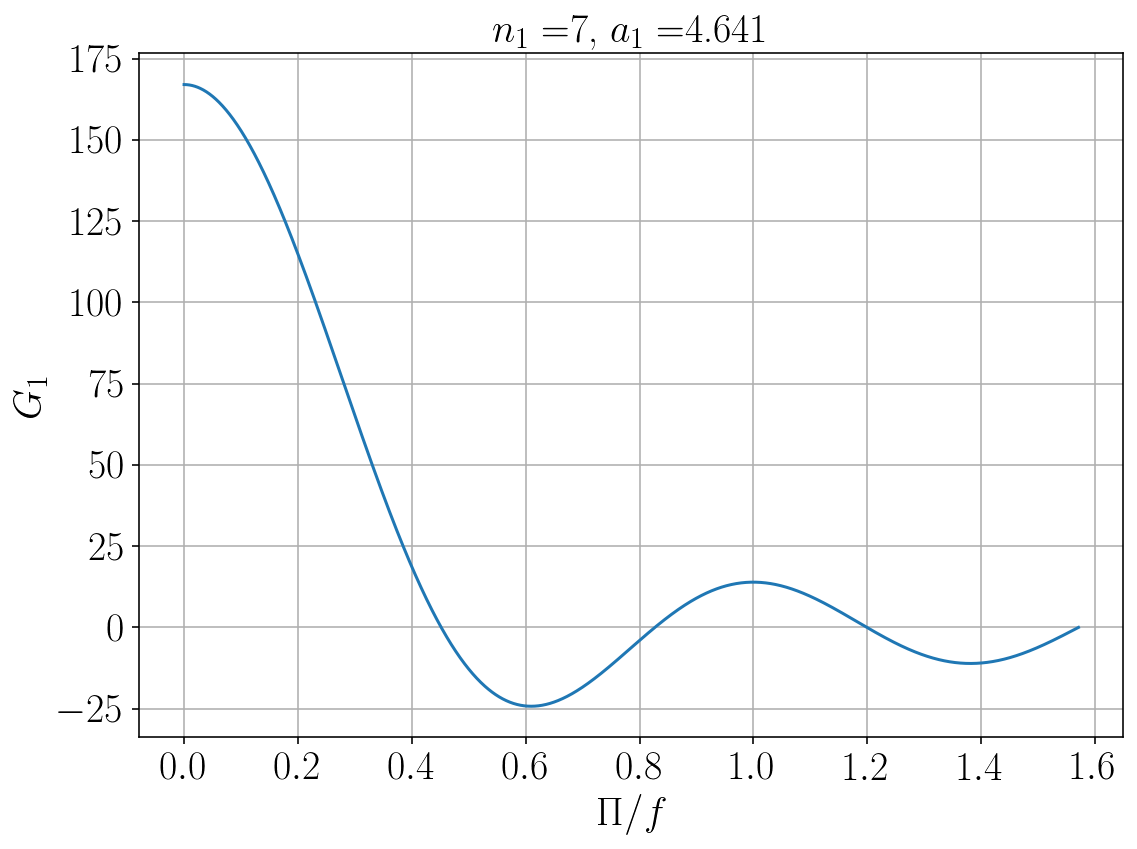

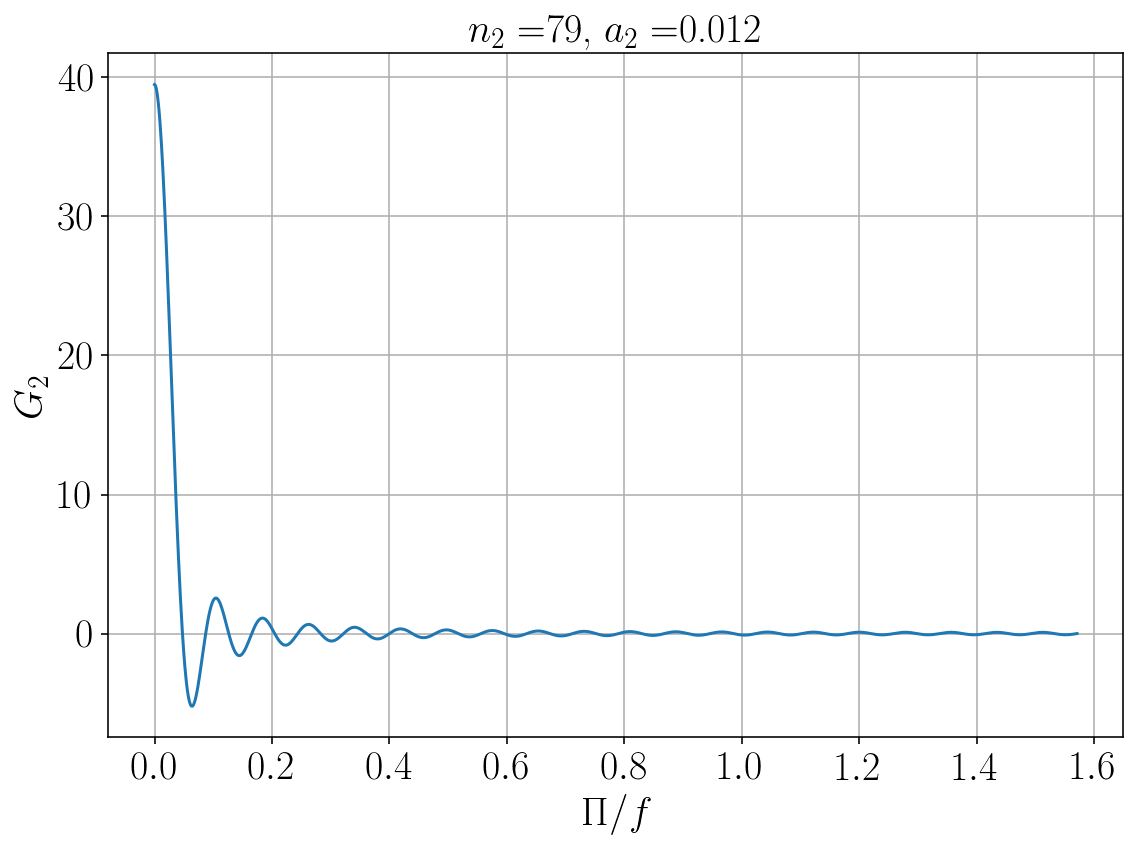

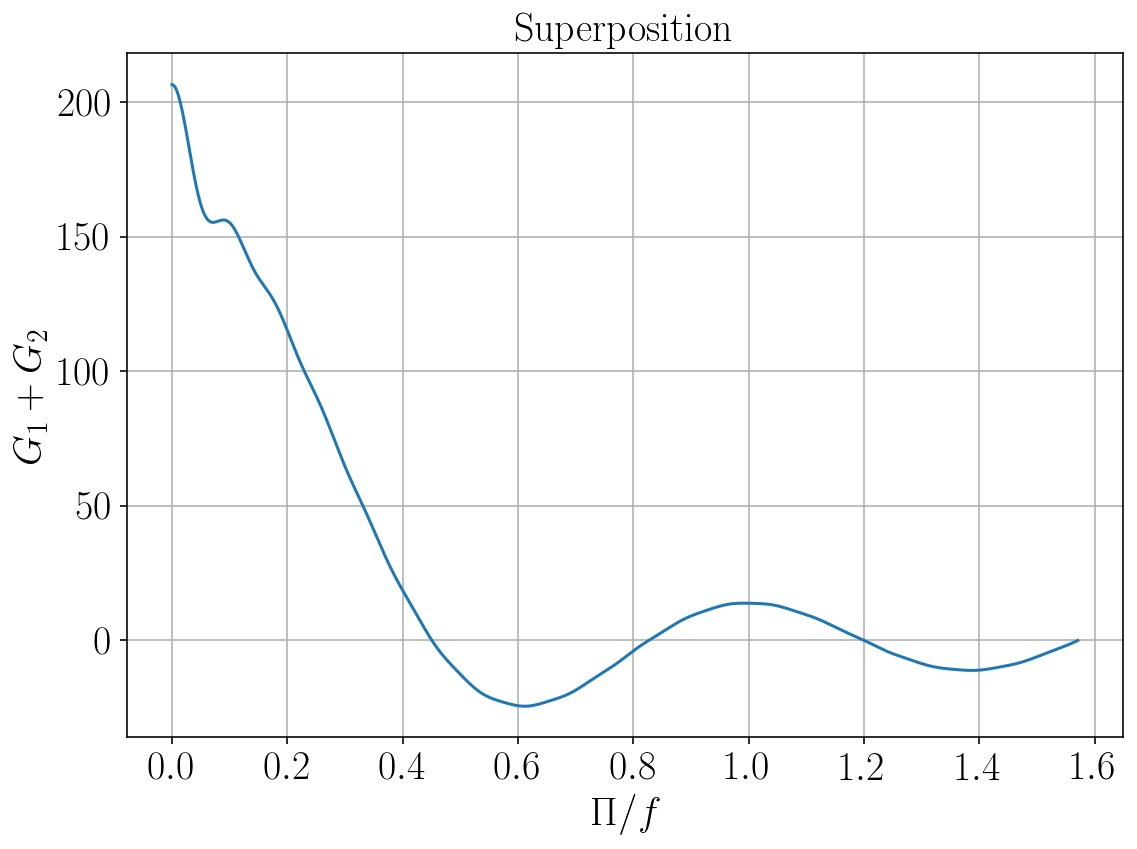

In [5]:
lam=1.5
n2_least=-lam/2 + np.sqrt(lam**2/4 + n1*(n1+2*lam)*abs(a1/a2))
n2_least=-lam/2 + np.sqrt(lam**2/4 + n1*(n1+2*lam)*abs(a1/a2))
print("Minimum value of next Gegenbauer is n2=",n2_least)
print("Which ceils to n2=",np.int(np.ceil(n2_least)))

myargs={"Ngb":4,"na_coeffs":[(n1, a1)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_1$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("$n_1=$"+str(int(n1))+", $a_1=$"+str(np.round(a1,3)),size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_1.pdf', dpi=300)
plt.show()


myargs={"Ngb":4,"na_coeffs":[(n2, a2)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_2$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("$n_2=$"+str(int(n2))+", $a_2=$"+str(np.round(a2,3)),size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_2.pdf', dpi=300)
plt.show()

myargs={"Ngb":4,"na_coeffs":[(n1, a1),(n2, a2)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_1+G_2$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("Superposition",size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_3.pdf', dpi=300)
plt.show()

True vacuum are h= [ 246.2         556.67527151  860.36307435 1162.61111111 1464.55062657]
Confinement scale f= 1028.404344193818


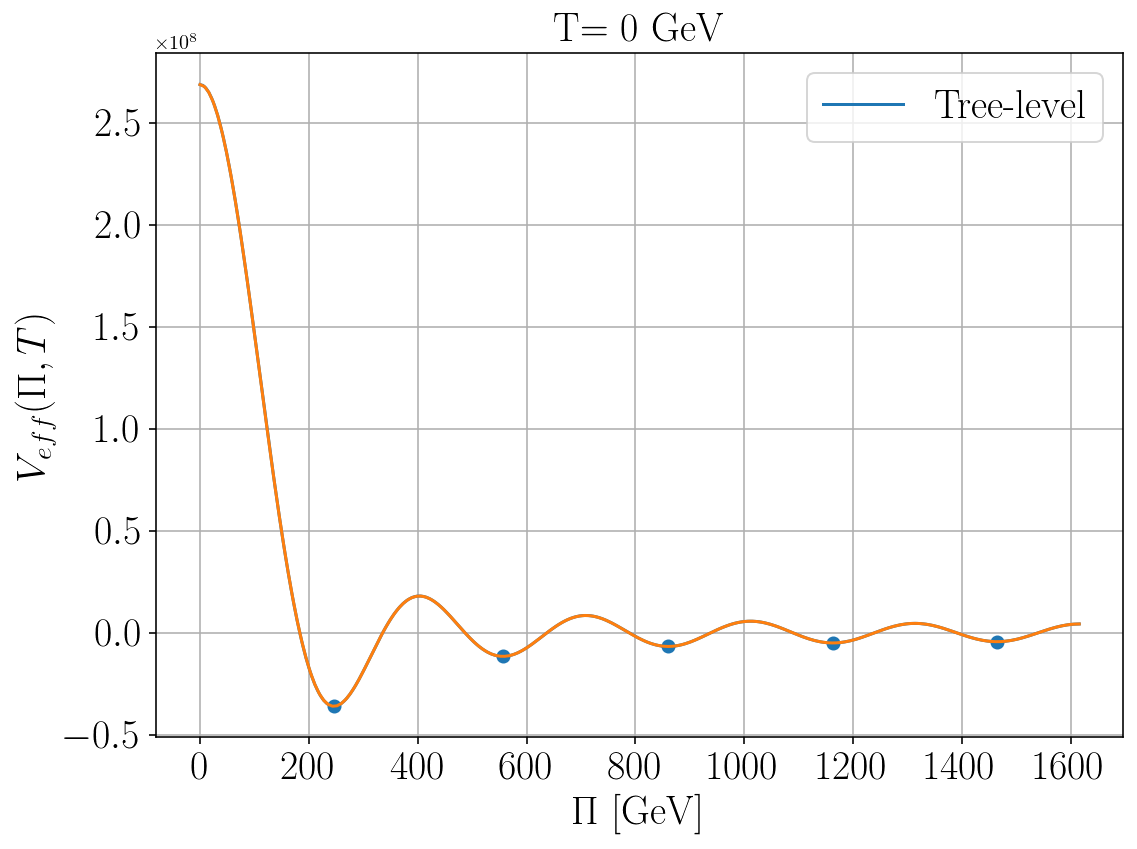

In [4]:
#BM1={'Ngb': 4, 'na_coeffs': [(21, 1), (66, 0.1)]}
#BM2={'Ngb': 4, 'na_coeffs': [(20, 1), (65, 0.1)]}
#BM3={'Ngb': 4, 'na_coeffs': [(22, 1), (67,0.1)]} ##Two PTs
#myargs={'Ngb': 4, 'na_coeffs': [(7, 30), (10, -.0001),(55,10)]} ##Very interesting!!!
#myargs={'Ngb': 4, 'na_coeffs': [(7, 30), (10, -.0001),(55,10),(100,-.1)]}
#myargs={'Ngb': 4, 'na_coeffs': [(7, -50), (10, -10),(55,4.2),(100,-.1)]}
#myargs={"Ngb":4,"na_coeffs":[(n1, a1),(n2, a2)]}
#myargs={'Ngb': 4, 'na_coeffs': [(20, 1)]} 
#myargs={'Ngb': 4, 'na_coeffs': [(5, 25),(40,-.2),(90,.07)]} 

#n1,n2,a1,a2= 9,99,9.71,0.017 #BM1
#n1,n2,a1,a2= 19,64,1,0.1 #BM2
#n1,n2,a1,a2= 7,79,4.641,0.012 #BM3

n1,a1=  20,1
myargs={'Ngb': 4, 'na_coeffs': [(n1, a1)]}

#myargs={'Ngb': 4, 'na_coeffs': [(n1, a1), (n2, a2)]}
m=model1(myargs)
m.include_CW=False

print("True vacuum are h=",m.vacua_list*m.f)
print("Confinement scale f=",m.f)

m.plot1()
m.plot2(0)
#plt.xlim(0,1000)

In [11]:
m.const/m.f**4

1.040295122193992e-06

In [12]:
m.adict

{'Ngb': 4, 'na_coeffs': [(20, 1)]}

In [13]:
m.vacua_list*m.f

array([ 246.2       ,  556.67527151,  860.36307435, 1162.61111111,
       1464.55062657])

In [14]:
m.Higgs_trilinear()

-0.9876035030547685

In [15]:
m.isEWSB()

The global minimum is
[-36068952.04019087] [245.98539772]


(array([-36068952.04019087]), array([245.98539772]))

In [16]:
%%time
m.findTrestoration()

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 3.64 s, sys: 25.2 ms, total: 3.66 s
Wall time: 3.66 s


260.46494837917834

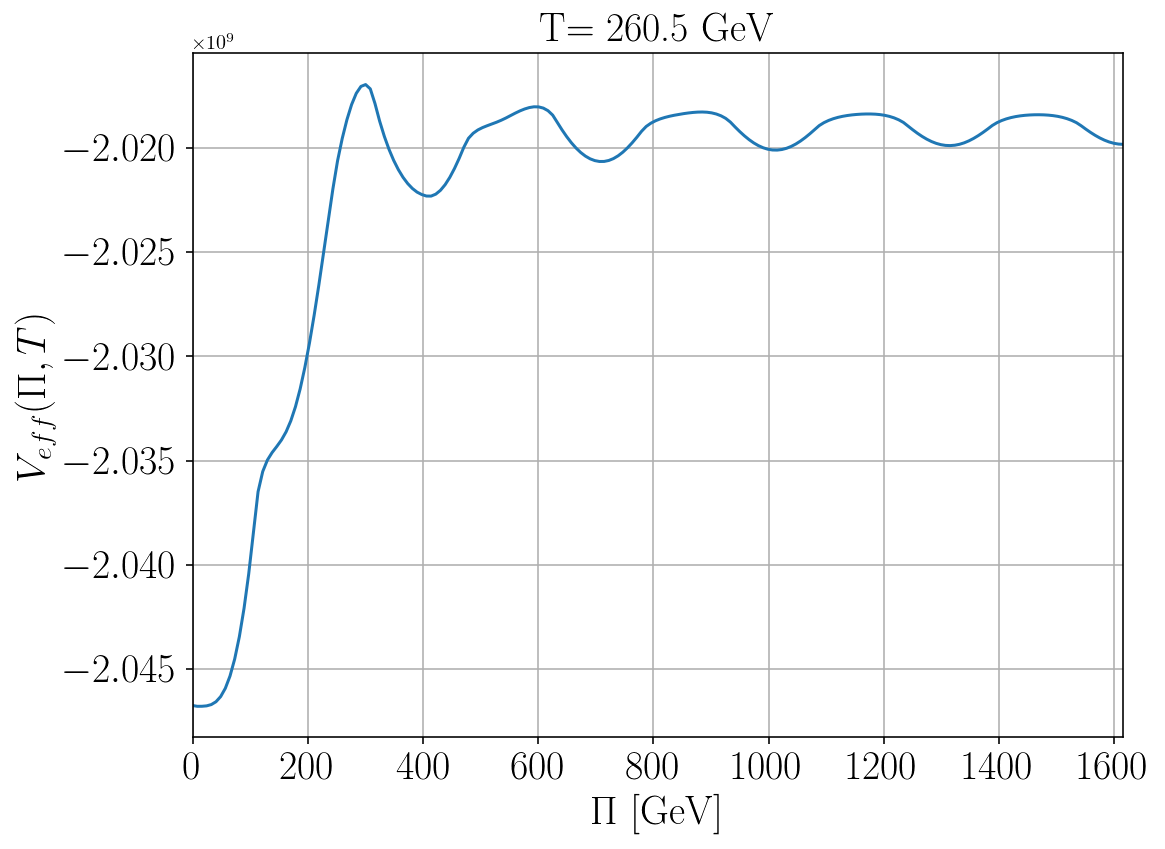

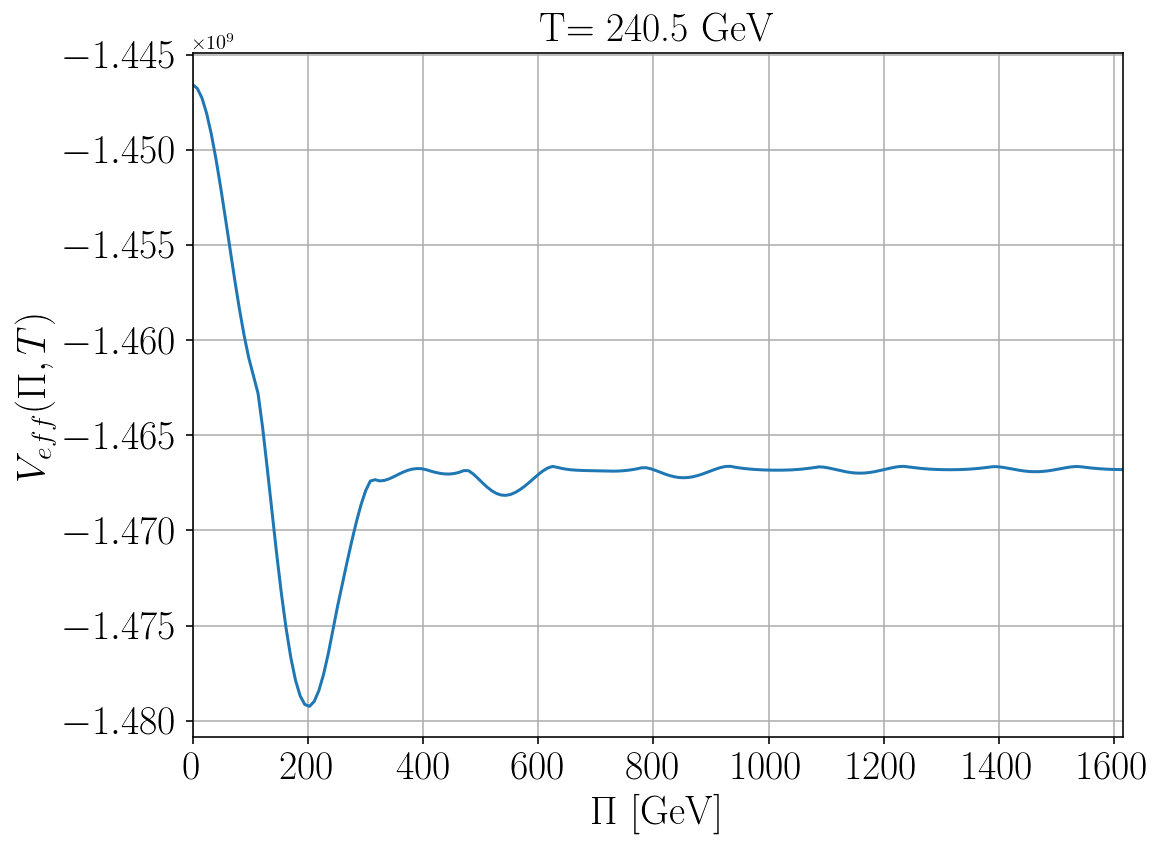

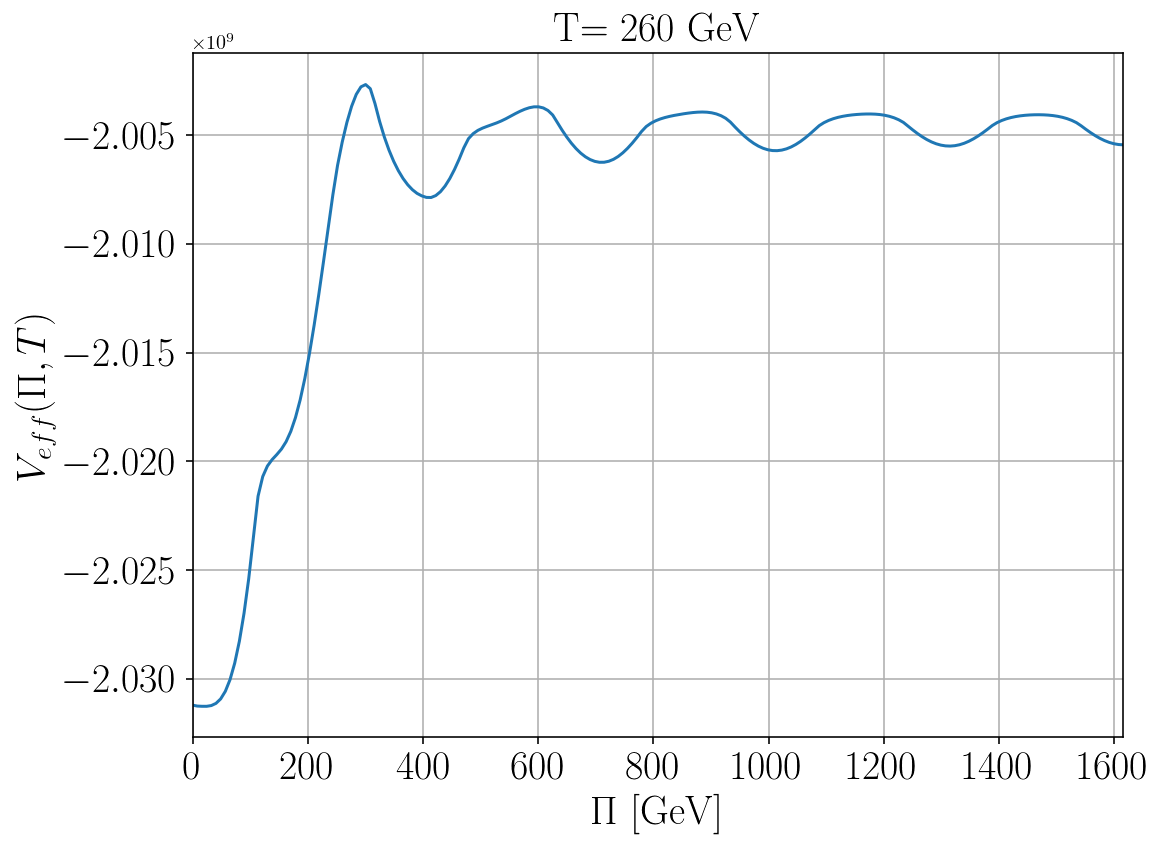

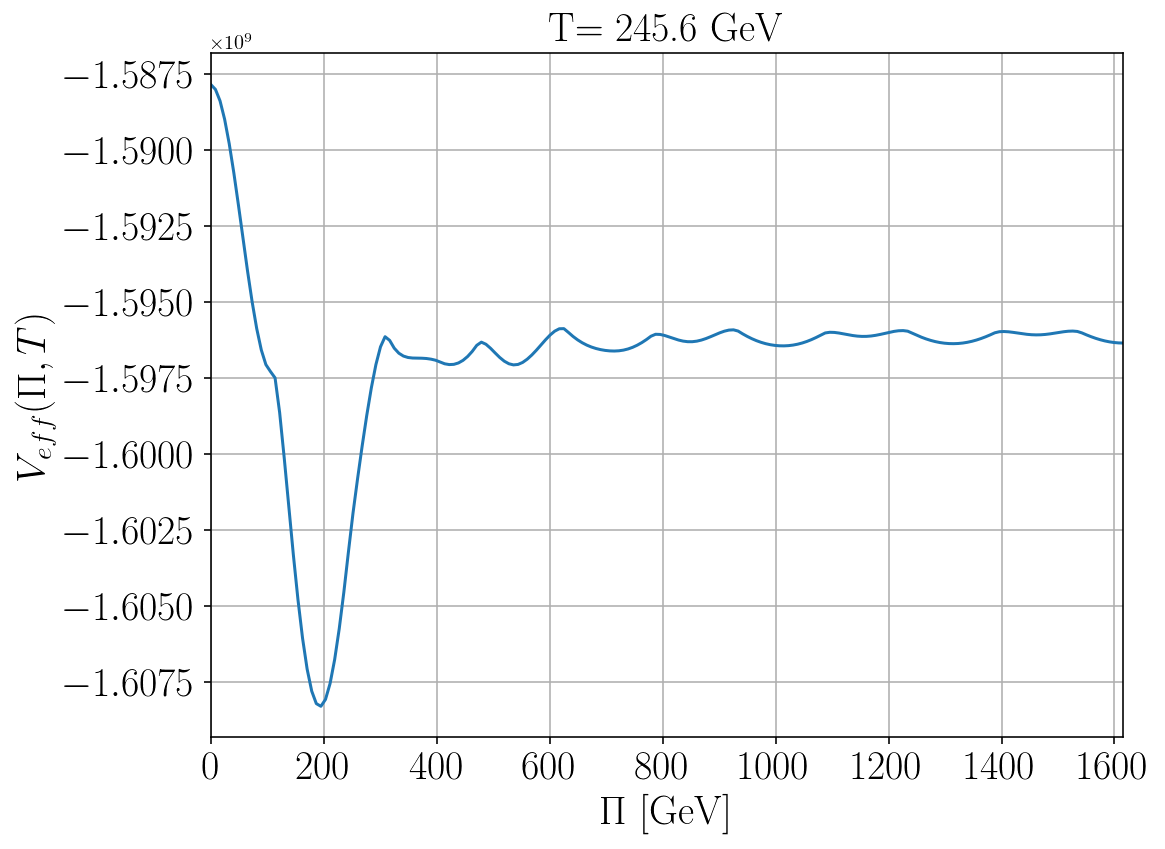

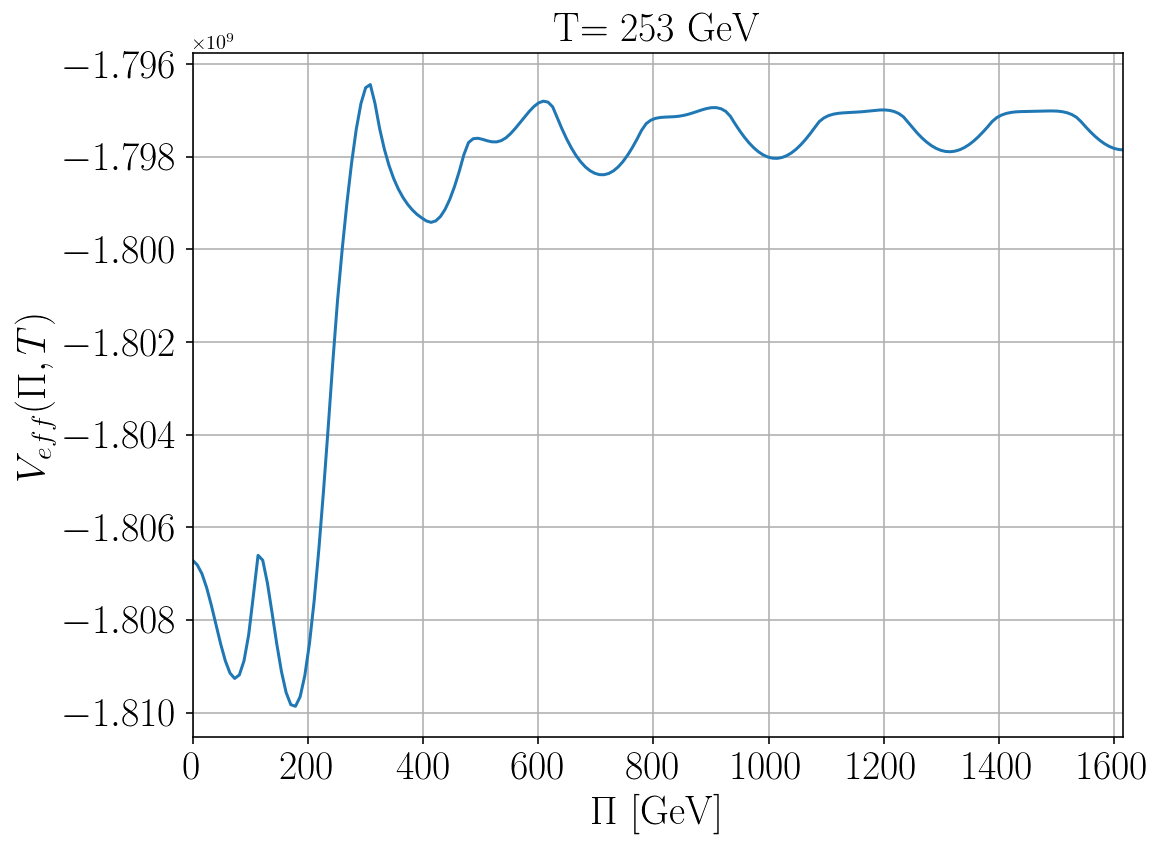

In [21]:
Temp=m.Trestored
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()



Temp=m.Trestored-20
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=260
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=245.6
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=253
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

In [13]:
%%time
m.minTracker()

CPU times: user 13min 25s, sys: 2.12 s, total: 13min 27s
Wall time: 13min 28s


{'phase_0': {'phi': array([ 9.1,  9.1,  9.1, ..., 11.6, 11.6, 11.6]),
  'T': array([183.4, 183.3, 183.2, ...,  68.8,  68.7,  68.6]),
  'interp': <scipy.interpolate.interpolate.interp1d at 0x7fa291d0cef8>},
 'phase_1': {'phi': array([44.6, 44.6, 44.6, ..., 49.3, 49.3, 49.3]),
  'T': array([183.4, 183.3, 183.2, ...,  76.5,  76.4,  76.3]),
  'interp': <scipy.interpolate.interpolate.interp1d at 0x7fa291a6ee08>},
 'phase_2': {'phi': array([75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. ,
         75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. ,
         75. , 75. , 75. , 75. , 75. , 75. , 75.1, 75.1, 75.1, 75.1, 75.1,
         75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1,
         75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1,
         75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1,
         75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.1, 75.2, 75.2, 75.2, 75.2,
         75.2, 75.2, 75.2, 75.2, 75.2, 75.2, 

In [14]:
m.phases.keys()

dict_keys(['phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_5', 'phase_6', 'phase_7', 'phase_8', 'phase_9', 'phase_10', 'phase_11', 'phase_12', 'phase_13', 'phase_14', 'phase_15'])

In [15]:
%%time
m.findTcritical()

Tunnel possible from phase_0  to phase_7

 Critical temperature found, Tc= 161.84915038204272 

CPU times: user 645 ms, sys: 27.4 ms, total: 672 ms
Wall time: 646 ms


In [16]:
phases_list=list(np.unique([[m.Tc[i][-1]["high_phase"],m.Tc[i][-1]["low_phase"]] for i in range(len(m.Tc))]))
phases_list

['phase_0', 'phase_7']

CPU times: user 305 ms, sys: 133 ms, total: 439 ms
Wall time: 284 ms


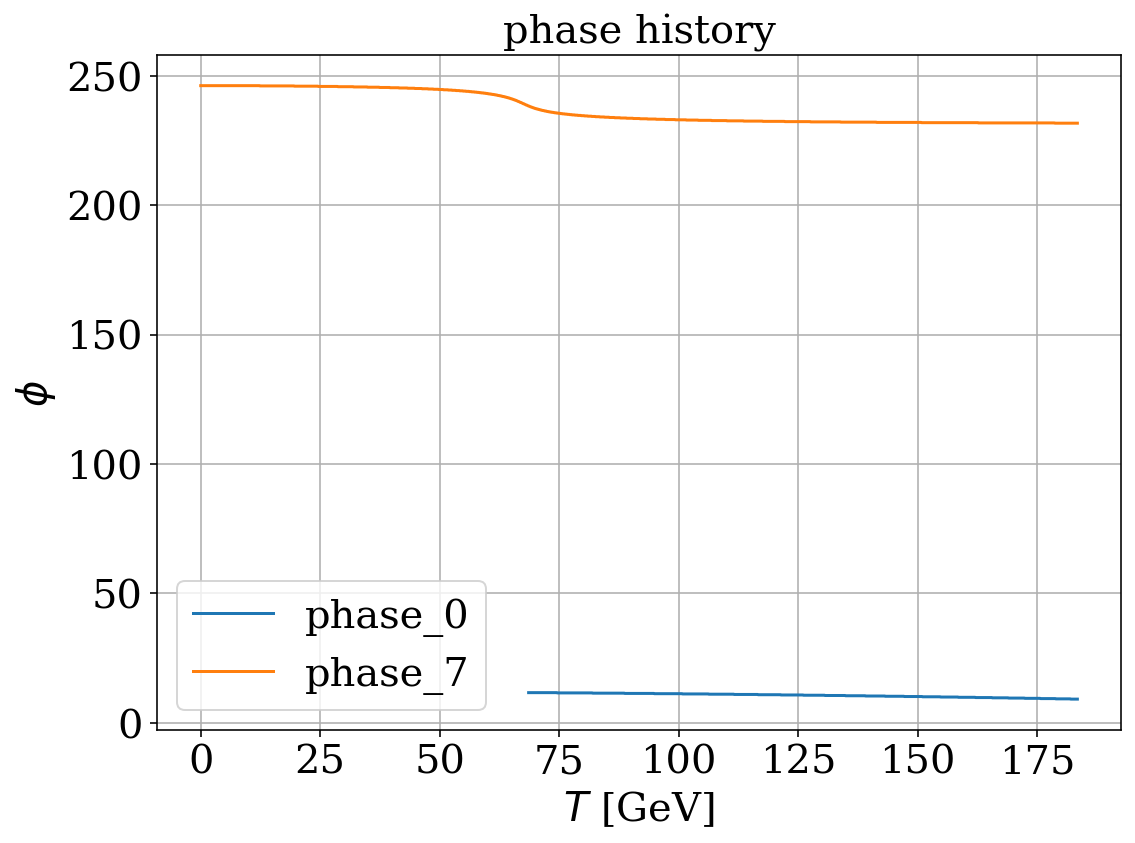

In [17]:
%%time
m.plot3(phases_list)  
plt.legend(loc="best",prop={'size': label_size})
plt.savefig('./PLOTS/G_hierachical_phase_hist.pdf', dpi=300)


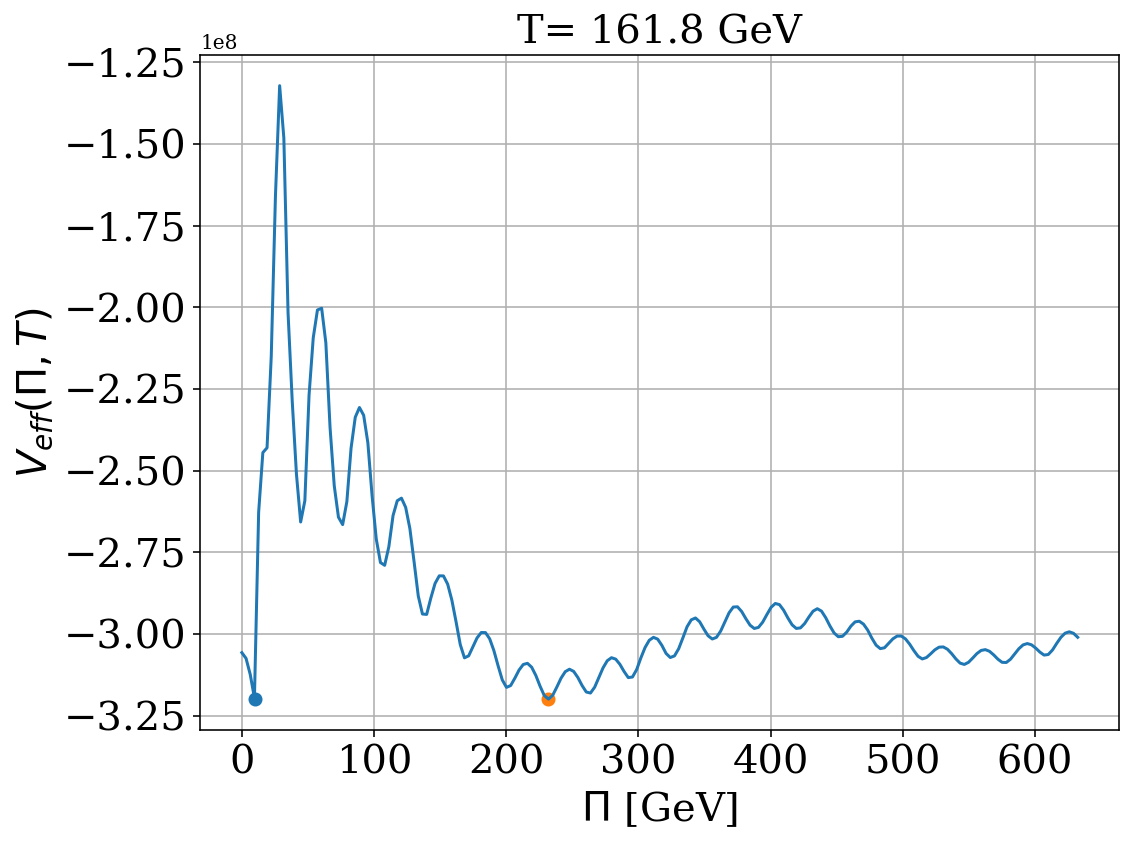

In [18]:
index_trans=0
phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]["interp"]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]["interp"]

Temp=m.Tc[index_trans][-1]["Tc"]
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp))
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp))
#plt.xlim(200,250)
#plt.savefig('./PLOTS/G_hierachical_T1.pdf', dpi=300)
plt.show()

In [19]:
phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]
Tmin=m.Tc[index_trans][-1]["Tmin"]
nucleation_list=[]
for temp in np.linspace(Tmin,m.Tc[index_trans][-1]["Tc"]):
    try:
        nuc_output=m.nucleation(phase_high,phase_low,temp)
        if len(nuc_output)!=0:
            nucleation_list.append(nuc_output)
    except:
        continue
    
df_nuc=pd.DataFrame(nucleation_list).dropna()


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandm

stable not metastable


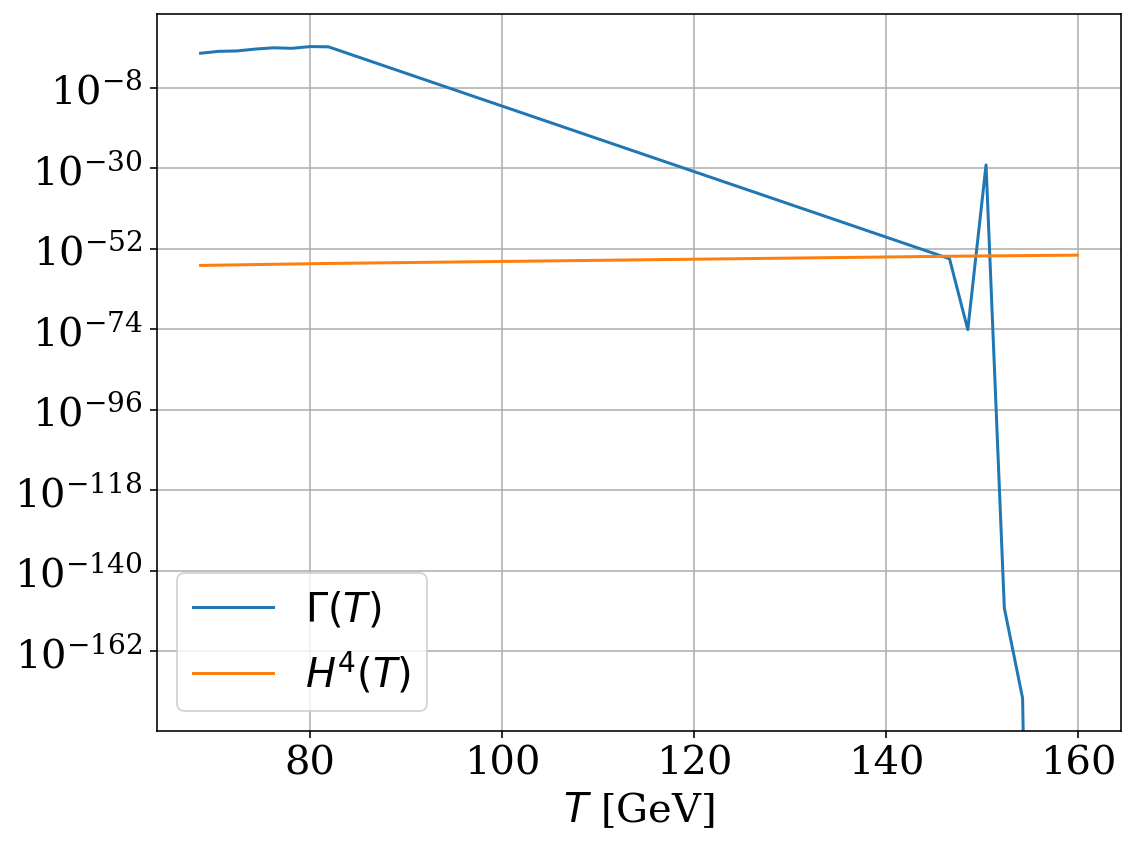

In [20]:
plt.plot(df_nuc["Tn"],df_nuc["Gamma"],label="$\Gamma(T)$")
plt.plot(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2,label="$H^4(T)$")
#plt.plot(df_nuc["Tn"],N_nuc(df_nuc["Tn"])+1)
plt.yscale("log")

plt.xlabel("$T$ [GeV]",size=label_size)
#plt.ylabel("$\Gamma/H^4$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend()
plt.legend(prop={'size': label_size})
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/Nucleation_1.pdf', dpi=300)
plt.show()

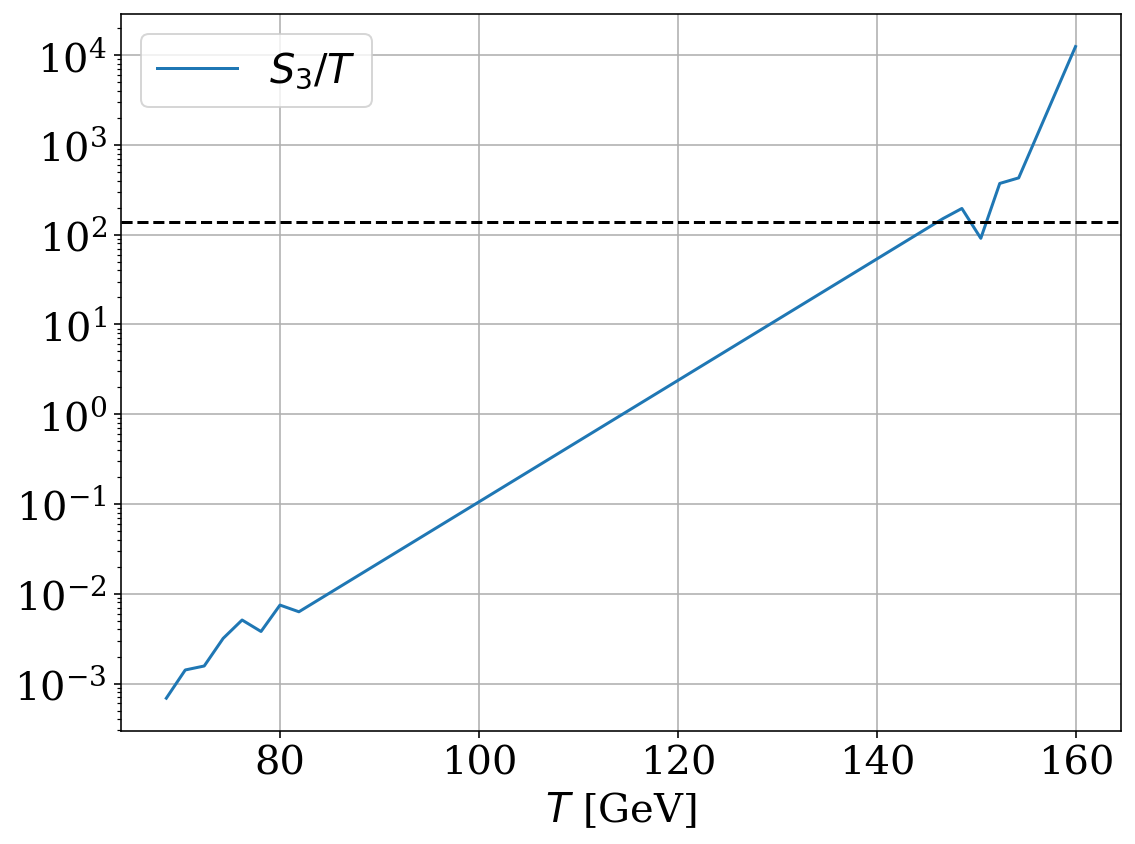

In [21]:
plt.plot(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"],label="$S_3/T$")
plt.yscale("log")
plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(prop={'size': label_size})
plt.axhline(y=140,c="k",linestyle="--",label="140")

plt.tight_layout()
plt.savefig('./PLOTS/Nucleation_2.pdf', dpi=300)
plt.show()

In [22]:

N_nuc=interpolate.interp1d(df_nuc["Tn"],df_nuc["Gamma"]/(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2-1)
Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])


S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-2, n=1)



0.004638062464434292


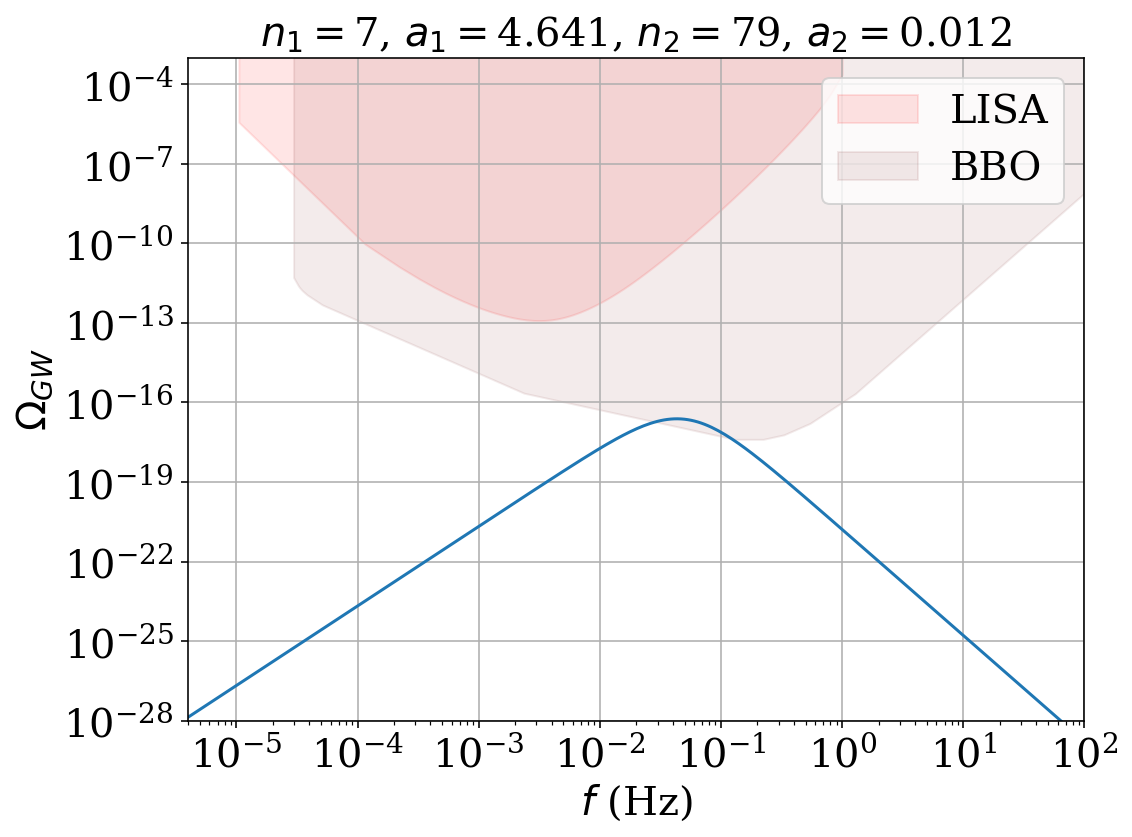

In [23]:
Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,vel_inter(Tnuc)
my_signal=GW_signal(Temp,al,beta,vel)
SNR_signal=SNR_GW(my_signal)

print(SNR_signal)

plt.plot(my_signal[0],my_signal[1])
#plt.plot(LISA_sens[::,0],LISA_sens[::,3],color="g")
plt.fill_between(LISA_sens[::,0],LISA_sens[::,3], 1e-2, alpha=0.1,color="#FF0000",label="LISA")

#plt.plot(BBO_sens["f"],BBO_sens["Omega_lim"],color="b")
plt.fill_between(BBO_sens["f"],BBO_sens["Omega_lim"], 1e-2, alpha=0.08,color="#660000",label="BBO")
plt.legend(prop={'size': label_size})

#plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
#plt.figtext(.4, .72, "LISA", fontsize=label_size)
plt.ylim(1e-28,1e-3)
plt.xlim(10**(-5.4),100)
plt.title("$n_1=$"+str(int(n1))+", $a_1=$"+str(np.round(a1,3))+", $n_2=$"+str(int(n2))+", $a_2=$"+str(np.round(a2,3)),size=label_size)
plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{GW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
plt.savefig('./PLOTS/GW.pdf', dpi=300)


In [24]:
m.chhh

0.6348340067883927

In [25]:
Temp,al,beta,vel

(146.62479929926107, array(0.0112612), 1905.6284272083558, array(0.57249715))

In [26]:
df_tot.iloc[0]

n1                       7
a1                 4.64074
n2                      79
a2               0.0121858
EWSB                  True
chh               0.634869
Tres               163.498
Tc_0               161.849
phi_false_0           10.2
phi_true_0             232
Tn_0               146.625
alpha_0          0.0112612
beta_0             1905.27
vw_0              0.572497
vJ_0              0.657322
SNR_0            0.0046418
Tc_1                   NaN
phi_false_1            NaN
phi_true_1             NaN
Tn_1                   NaN
alpha_1                NaN
beta_1                 NaN
vw_1                   NaN
vJ_1                   NaN
SNR_1                  NaN
Tc_2                   NaN
phi_false_2            NaN
phi_true_2             NaN
Tn_2                   NaN
alpha_2                NaN
beta_2                 NaN
vw_2                   NaN
vJ_2                   NaN
SNR_2                  NaN
Tc_3                   NaN
phi_false_3            NaN
phi_true_3             NaN
T

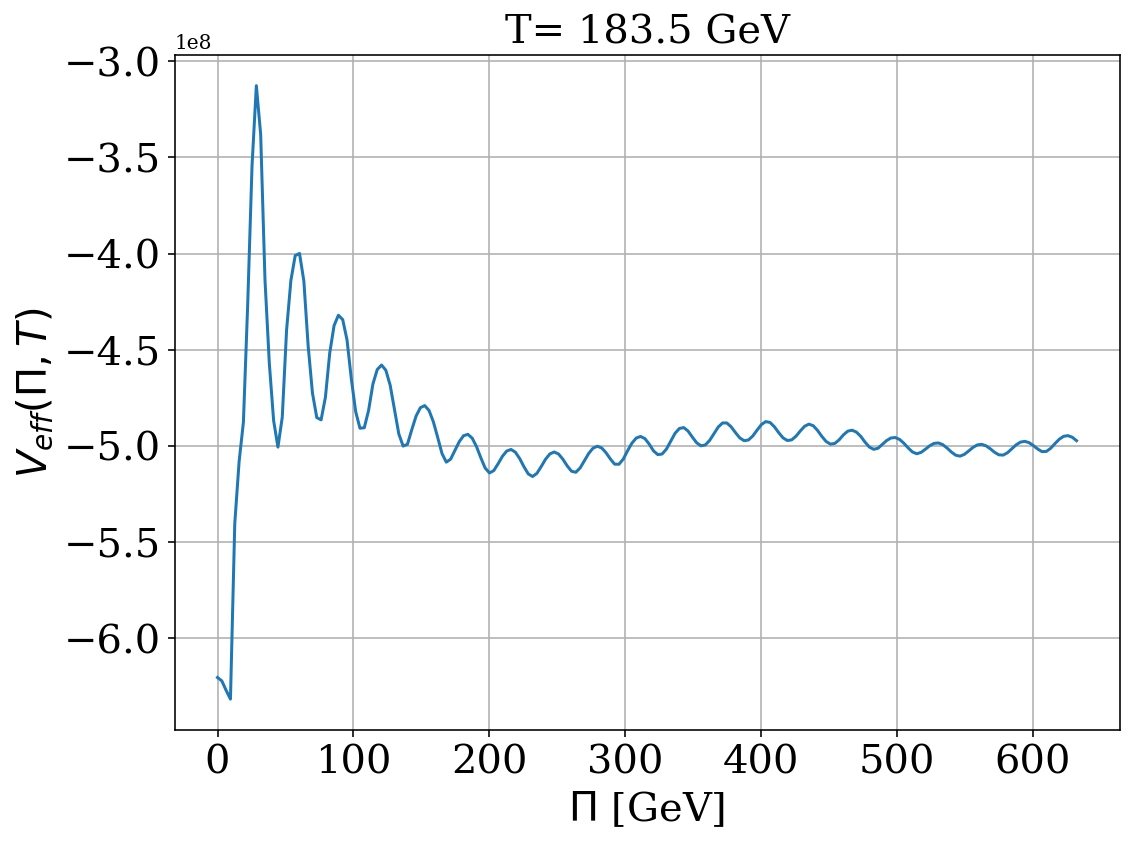

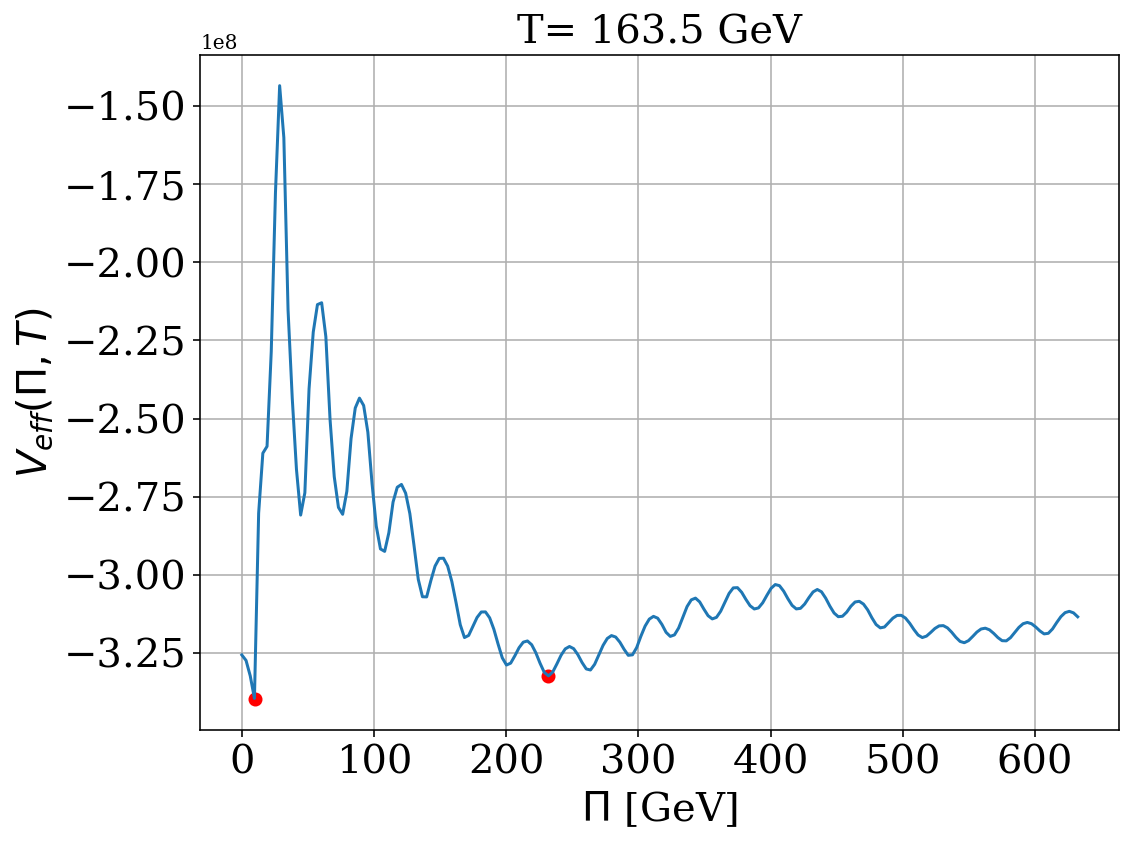

In [27]:


phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]["interp"]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]["interp"]



Temp=m.Trestored+20
m.plot2(Temp)
#plt.xlim(0,m.f)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_T0.pdf', dpi=300)
plt.show()

Temp=m.Trestored
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp),color="r")
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp),color="r")
#plt.xlim(0,m.f)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_T1.pdf', dpi=300)
plt.show()





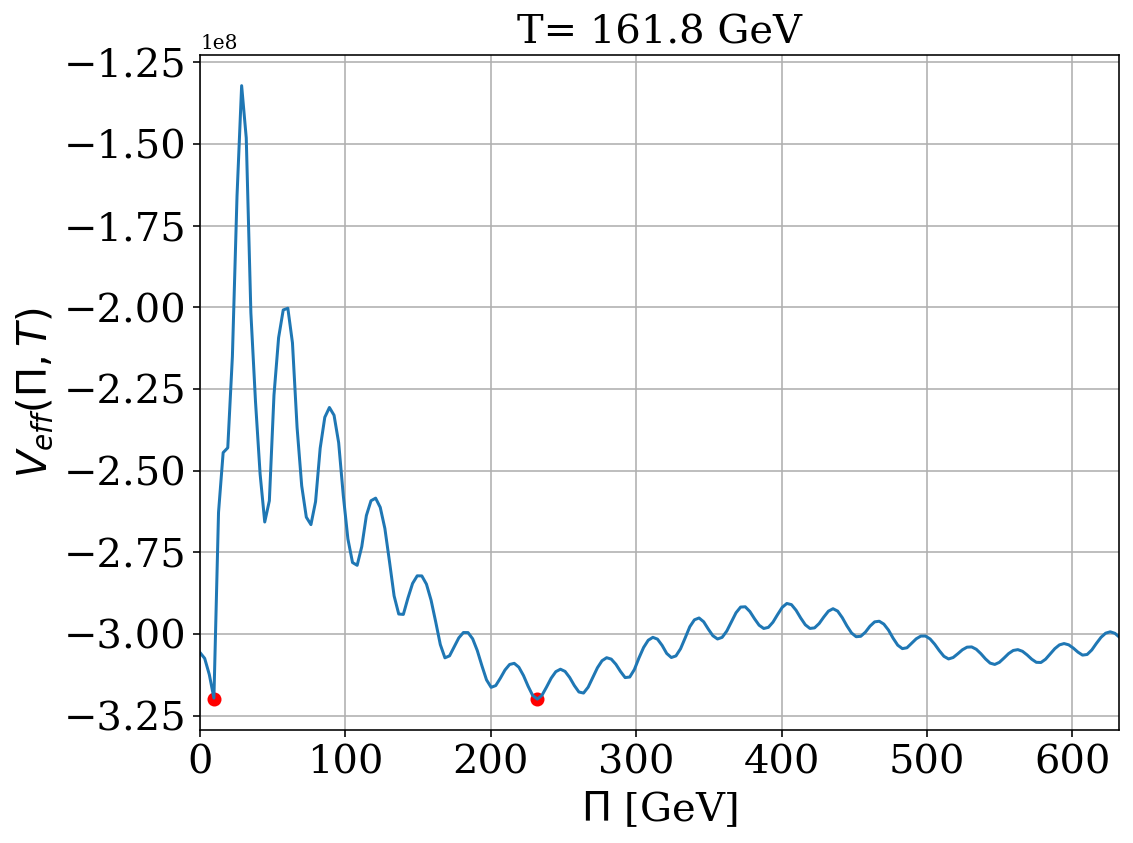

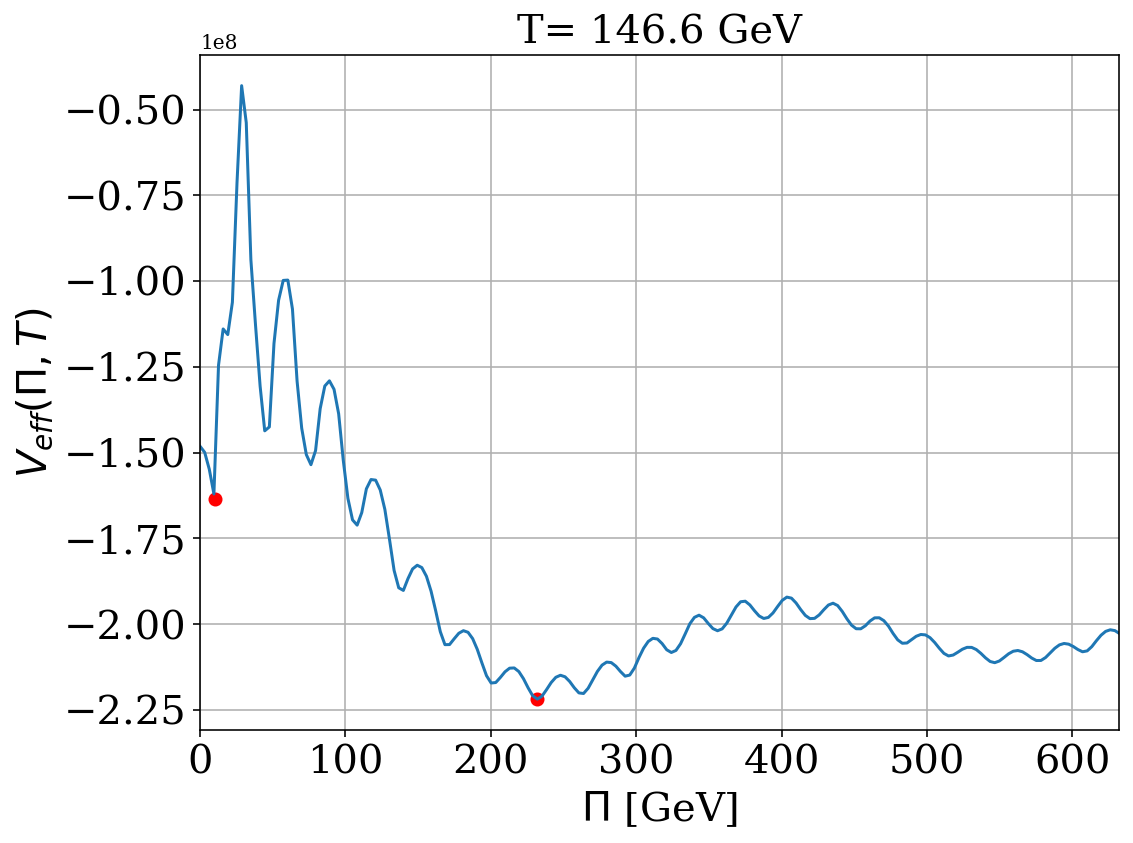

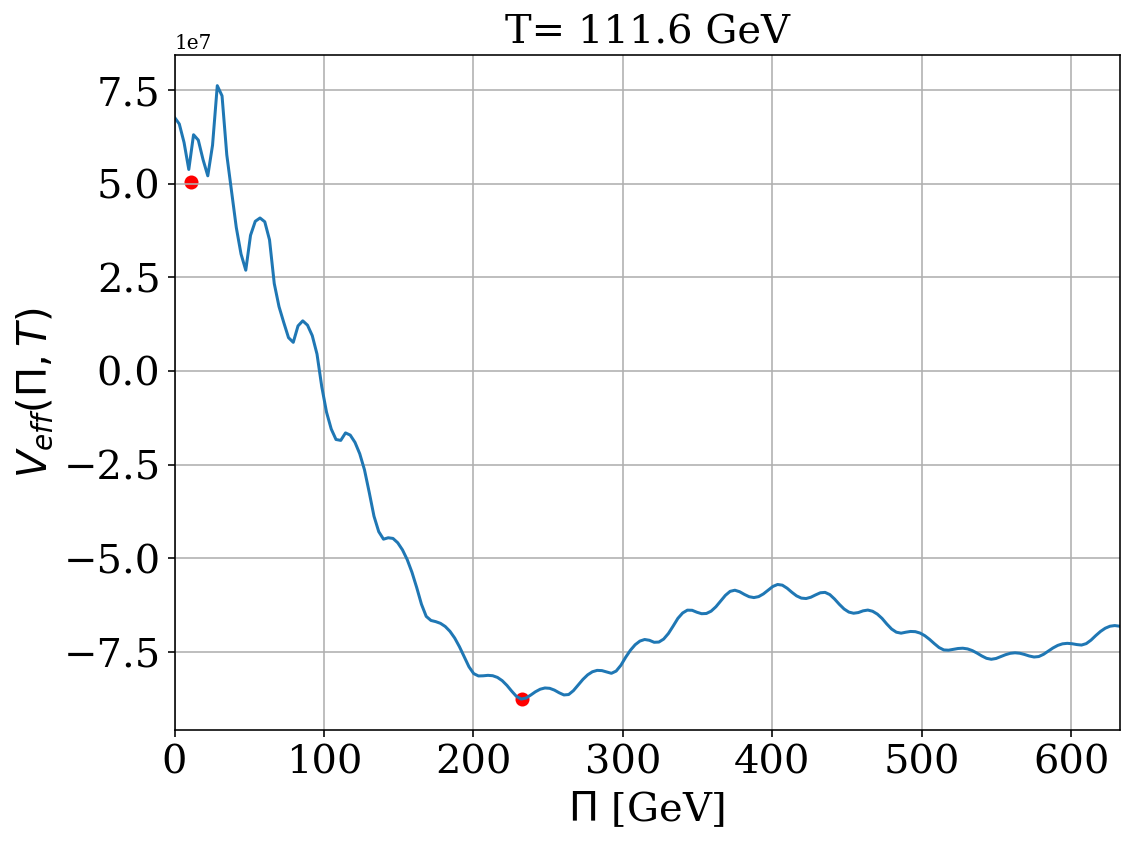

In [36]:
Temp=m.Tc[index_trans][-1]["Tc"]
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp),color="r")
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp),color="r")
plt.xlim(0,m.f*np.pi/2)
#plt.savefig('./PLOTS/G_hierachical_T3.pdf', dpi=300)
plt.tight_layout()
plt.show()


Temp=Tnuc
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp),color="r")
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp),color="r")
plt.xlim(0,m.f*np.pi/2)
plt.savefig('./PLOTS/G_hierachical_T3.pdf', dpi=300)
plt.tight_layout()
plt.show()


Temp=Tnuc-35
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp),color="r")
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp),color="r")
plt.xlim(0,m.f*np.pi/2)
plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.tight_layout()
plt.show()
